<b>Autor:</b> Edwin Rueda <br>
<b>email:</b> ejrueda95g@gmail.com <br>
<b>github:</b> https://github.com/ejrueda <br>
<b>website:</b> http://edwinrueda.com/ <br>
<b> You can cite this work with</b>:

@software{edwin_rueda_2020_3843381,<br>
  author       = {Edwin Rueda},<br>
  title        = {ejrueda/MasterUFPA: zenodo release},<br>
  month        = may,<br>
  year         = 2020,<br>
  publisher    = {Zenodo},<br>
  version      = {zenodo},<br>
  doi          = {10.5281/zenodo.3843381},<br>
  url          = {https://doi.org/10.5281/zenodo.3843381}<br>
}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

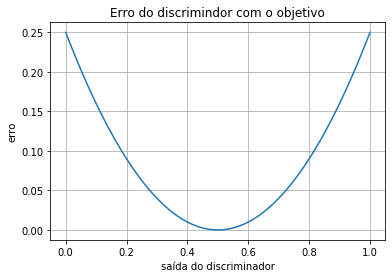

In [4]:
x = np.linspace(0,1,100)
plt.title("Erro do discrimindor com o objetivo")
plt.xlabel("saída do discriminador")
plt.ylabel("erro")
plt.plot(x, (x-.5)**2);
plt.grid();